In [2]:
# Install Necessory Libraries

In [3]:
!pip install transformers torch accelerate -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 41.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 66.3 MB/s eta 0:00:00


In [4]:
# Loading PreTrained BERT Model

In [5]:

from transformers import BertTokenizer, BertModel
# load pre-trained model and tokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')


# tokenizer input text
text= "Hello, how are you ?"

inputs = tokenizer(text, return_tensors = 'pt')


# get the embeddings
outputs = model(**inputs)
last_hidden_states = outputs.last_hidden_state

print(last_hidden_states.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

torch.Size([1, 8, 768])


In [6]:
# Fine Tuning BERT for Specific Task

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer , TrainingArguments

import torch
from torch.utils.data import DataLoader,Dataset

In [8]:
# IMBD DATASET LOAD

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import pandas as pd

In [11]:
df = pd.read_csv('/content/drive/MyDrive/NLP_PROJECT/Movie_Review_Sentiment_Analysis _Bert/IMDB Dataset.csv')

In [12]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [13]:
df['sentiment'].value_counts()

,count
sentiment,
positive,25000
negative,25000


In [14]:
# Create Labels
def sentiments_to_labels(sentiment):
  if sentiment == "positive":
      return 1
  elif sentiment =='negative':
      return 0
  else:
      return None

df['labels'] = df['sentiment'].apply(sentiments_to_labels)

df.head()


,review,sentiment,labels
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [15]:
# Split data and use only 2k for training and 100 for testing

In [16]:
df = df.drop(columns='sentiment')

In [17]:

df.head()

texts = df['review'].head(2000)
labels= df['labels'].head(2000)


# testing datase created 100 for evaluation
test_reviews = list(df['review'].head(100))
test_labels =  list(df['labels'].head(100))


In [18]:
# Dataset Preparation
# Dataset Class: Defined sampleDataset class inherits from Dataset, designed to handle text classification tasks using BERT.

# Initialization: Accepts texts, labels, tokenizer, and max_len parameters.
# __len__ Method: Returns the length of the dataset.
# __getitem__ Method: Tokenizes each text using the tokenizer, truncates/pads to max_len, and returns input_ids, attention_mask, and labels.

# Data Preparation:

# texts and labels are extracted from df['review'] and df['labels'] respectively.
# tokenizer is initialized using BertTokenizer.from_pretrained.
# dataset is created using sampleDataset with texts, labels, tokenizer, and max_len=32.
# dataloader is created using DataLoader for batching.

# Model Training

# Model Loading:
# model is loaded using BertForSequenceClassification.from_pretrained with num_labels=2 for binary classification.

# Training Arguments:
# Initial training arguments (commented out) include output directory, epochs, batch size, and logging settings.
# Hyperparameter tuning: New training_args with 5 epochs, batch size 4, learning rate 5e-5, and increased logging steps.

# Trainer Initialization:
# trainer is initialized with model, training_args, and train_dataset.

# Training:
# trainer.train() initiates the training process.

# Evaluation:
# results from trainer.evaluate(eval_dataset=dataset) provides evaluation metrics after training.


In [23]:
class sampleDataset(Dataset):
  def __init__(self, texts, labels, tokenizer, max_len):
    self.texts = texts
    self.labels = labels
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = self.texts[idx]
    label= self.labels[idx]
    encoding = self.tokenizer(text, truncation= True, padding='max_length', max_length= self.max_len, return_tensors = 'pt')

    return {

            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label,dtype=torch.long)

        }

# prepare the dataset
texts = df['review'].head(2000)
labels= df['labels'].head(2000)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
dataset = sampleDataset(texts, labels, tokenizer, max_len=32)

# create dataloader
dataloader = DataLoader(dataset, batch_size=2)

# load Model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels = 2)

# # training arguments
# training_args = TrainingArguments(
#     output_dir = '.results',  # output directory
#     num_train_epochs = 1, # number of training epochs
#     per_device_train_batch_size=2, # batch size for training
#     logging_dir ='./logs',

# )
"""The above parameter are working fine
{'eval_loss': 0.5178326368331909, 'eval_runtime': 15.8858, 'eval_samples_per_second': 125.899, 'eval_steps_per_second': 15.737, 'epoch': 1.0}
"""

# Hyper Parameter Tuning
# Define training arguments with different hyperparameters
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=5,
    per_device_train_batch_size=4,
    learning_rate=5e-5,
    logging_dir='./logs',
    logging_steps=10,
)
"""We are trying to do hyper parameter tuning and see the results
{'eval_loss': 0.02625814639031887, 'eval_runtime': 15.9143, 'eval_samples_per_second': 125.673, 'eval_steps_per_second': 15.709, 'epoch': 5.0}

Lower Evaluation Loss: eval_loss 0.026 from epoch 5 is significantly lower than eval_loss 0.51 from epoch 1.
 This suggests that the model's performance improved substantially as training progressed. Therefore, eval_loss 0.026 is better than eval_loss 0.51.

"""

# trainer
trainer = Trainer(
    model = model,
    args= training_args,
    train_dataset = dataset
)

trainer.train()

# evaluate the model
results = trainer.evaluate(eval_dataset=dataset)
print(results)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Step,Training Loss
10,0.755500
20,0.678800
30,0.688900
40,0.593100
50,0.700400
60,0.661400
70,0.704300
80,0.696500
90,0.731500
100,0.755400


{'eval_loss': 0.044098254293203354, 'eval_runtime': 244.6404, 'eval_samples_per_second': 8.175, 'eval_steps_per_second': 1.022, 'epoch': 5.0}


In [24]:
#  Save the Fine-Tuned Model & Tokenizer
from transformers import BertTokenizer

# Create the tokenizer (from pre-trained BERT or fine-tuned tokenizer)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Define the path where you want to save the model and tokenizer
model_save_path = "/content/drive/MyDrive/NLP_PROJECT/Movie_Review_Sentiment_Analysis_Bert/fine_tuned_bert_model"

# Save the fine-tuned model
trainer.save_model(model_save_path)

# Save the tokenizer
tokenizer.save_pretrained(model_save_path)

print(f"Model and tokenizer saved to {model_save_path}")


Model and tokenizer saved to /content/drive/MyDrive/NLP_PROJECT/Movie_Review_Sentiment_Analysis_Bert/fine_tuned_bert_model


In [25]:
# Load the Model & Tokenizer for Future Use
from transformers import BertForSequenceClassification, BertTokenizer

# Load the saved fine-tuned model and tokenizer
model = BertForSequenceClassification.from_pretrained(model_save_path)
tokenizer = BertTokenizer.from_pretrained(model_save_path)

model.eval()  # Set model to evaluation mode


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [29]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

# ✅ Example text for single prediction
text = "The movie was absolutely fantastic and engaging!"

# Tokenize single input
inputs = tokenizer(text, return_tensors="pt", truncation=True, padding='max_length', max_length=32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# Single prediction
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
predicted_class = torch.argmax(logits, dim=1).item()
labels_map = {0: "Negative", 1: "Positive"}
print(f"Predicted Sentiment: {labels_map[predicted_class]}")

# ✅ Example of Testing on New Data
new_texts = test_reviews  # List of new review texts

# Tokenize new data
inputs = tokenizer(new_texts, truncation=True, padding='max_length', max_length=32, return_tensors='pt')
input_ids = inputs['input_ids'].to(device)
attention_mask = inputs['attention_mask'].to(device)

# Predict on new data
with torch.no_grad():
    outputs = model(input_ids, attention_mask=attention_mask)
predicted_labels = torch.argmax(outputs.logits, dim=1)

# ✅ Display Predictions
for text, label in zip(new_texts[:10], predicted_labels[:10]):
    sentiment = "POSITIVE" if label == 1 else "NEGATIVE"
    print(f"Text: {text[:100]} ---> Predicted Label: {sentiment}")

# ✅ Evaluation with Classification Report & Confusion Matrix
true_labels = torch.tensor(test_labels)  # Assuming test_labels exist as ground truth
true_labels = true_labels.to(device)

# Convert to CPU & NumPy for sklearn metrics
predicted_labels = predicted_labels.cpu().numpy()
true_labels = true_labels.cpu().numpy()

# 📊 Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, predicted_labels, target_names=["Negative", "Positive"]))

# 📉 Confusion Matrix
print("Confusion Matrix:")
print(confusion_matrix(true_labels, predicted_labels))


Predicted Sentiment: Positive
Text: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The ---> Predicted Label: POSITIVE
Text: A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-B ---> Predicted Label: POSITIVE
Text: I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air con ---> Predicted Label: POSITIVE
Text: Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his par ---> Predicted Label: NEGATIVE
Text: Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers  ---> Predicted Label: POSITIVE
Text: Probably my all-time favorite movie, a story of selflessness, sacrifice and dedication to a noble ca ---> Predicted Label: POSITIVE
Text: I sure would like to see a resurrection of a up dated Seahunt series with the tech they have today i ---> Predicted Label: POSITIVE
Text

In [30]:
misclassified_index = [i for i, (true, pred) in enumerate(zip(true_labels, predicted_labels)) if true != pred]
print("Misclassified Review:", test_reviews[misclassified_index[0]])


Misclassified Review: This show was an amazing, fresh & innovative idea in the 70's when it first aired. The first 7 or 8 years were brilliant, but things dropped off after that. By 1990, the show was not really funny anymore, and it's continued its decline further to the complete waste of time it is today.<br /><br />It's truly disgraceful how far this show has fallen. The writing is painfully bad, the performances are almost as bad - if not for the mildly entertaining respite of the guest-hosts, this show probably wouldn't still be on the air. I find it so hard to believe that the same creator that hand-selected the original cast also chose the band of hacks that followed. How can one recognize such brilliance and then see fit to replace it with such mediocrity? I felt I must give 2 stars out of respect for the original cast that made this show such a huge success. As it is now, the show is just awful. I can't believe it's still on the air.


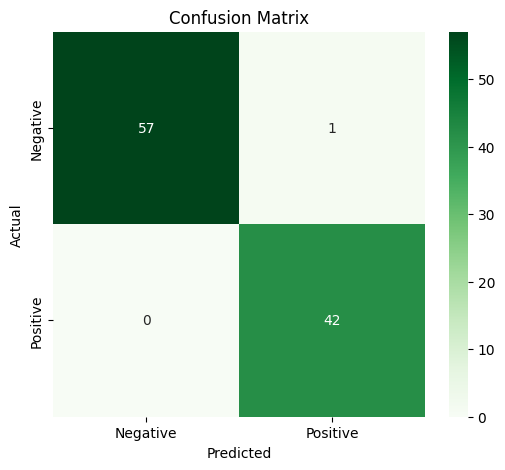

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [32]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

# Example list of multiple reviews
new_reviews = [
    "The movie was absolutely fantastic and engaging!",  # Positive
    "I didn't enjoy the film, it was boring and too long.",  # Negative
    "Great acting but the plot was predictable.",  # Mixed
    "Terrible storyline and bad acting.",  # Negative
    "An emotional rollercoaster, truly a masterpiece!"  # Positive
]

# ✅ Tokenize all reviews
inputs = tokenizer(new_reviews, truncation=True, padding='max_length', max_length=32, return_tensors='pt')

# ✅ Move to device (CPU/TPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {key: val.to(device) for key, val in inputs.items()}

# ✅ Get model predictions
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits
predicted_classes = torch.argmax(logits, dim=1)

# ✅ Map predictions to labels
labels_map = {0: "Negative", 1: "Positive"}

# ✅ Display results
for review, pred in zip(new_reviews, predicted_classes):
    print(f"Review: {review[:100]}")  # Show first 100 chars if long
    print(f"Predicted Sentiment: {labels_map[pred.item()]}")
    print("-" * 60)


Review: The movie was absolutely fantastic and engaging!
Predicted Sentiment: Positive
------------------------------------------------------------
Review: I didn't enjoy the film, it was boring and too long.
Predicted Sentiment: Negative
------------------------------------------------------------
Review: Great acting but the plot was predictable.
Predicted Sentiment: Negative
------------------------------------------------------------
Review: Terrible storyline and bad acting.
Predicted Sentiment: Negative
------------------------------------------------------------
Review: An emotional rollercoaster, truly a masterpiece!
Predicted Sentiment: Positive
------------------------------------------------------------
